In [211]:
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from torch import nn, distributions
from torch.distributions import constraints, transform_to
from sklearn.cluster import KMeans
from torch import optim
from tqdm.autonotebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [2]:
def whitened_KL(mz, Lz):

    Lz_diag = torch.diag(Lz)
    log_Lz_diag = torch.log(Lz_diag)

    M = len(mz)

    kl_term = -2*torch.sum(log_Lz_diag) + torch.sum(Lz_diag**2) + torch.sum(mz**2) - M

    return 0.5*kl_term

In [3]:
def add_jitter(K, jitter=1e-3):
    mat = K

    if mat.dim()==2:
        N, _ =  mat.shape
        mat.view(-1)[::N+1] += jitter
        return mat

    if mat.dim()==3:
        L, N, _ = mat.shape
        mat.view(L, -1)[:, ::N+1] += jitter
        return mat

In [4]:
class batched_RBF(nn.Module):
  def __init__(self, sigma=1.0, lengthscale=2.0):
    super().__init__()

    self.sigma = nn.Parameter(torch.tensor(sigma))
    self.lengthscale = nn.Parameter(torch.tensor(lengthscale))
    


  def covariance(self, x1, x2):

    diff = x1-x2
    dist = (diff**2).sum()

    return (self.sigma**2)*torch.exp(-0.5*dist/(self.lengthscale**2))


  def forward(self, X, Z, diag=False):
    
    if diag:
      return (self.sigma**2).unsqueeze(-1).expand(-1, X.size(0))
    

    result = torch.vmap(lambda x: torch.vmap(lambda y: self.covariance(x, y))(X))(Z)
    return torch.transpose(result, -1, 0)

In [5]:
class WSVGP(nn.Module):
  def __init__(self, kernel, dim=1, M=50, jitter=1e-4):
    super().__init__()
    self.kernel = kernel
    self.jitter = jitter
    
    self.Z = nn.Parameter(torch.randn((M, dim))) #choose random inducing points
   
    self.Lu = nn.Parameter(torch.randn((M,M)))
    self.mu = nn.Parameter(torch.zeros((M,)))
    self.constraint = constraints.lower_cholesky


  def kernel_forward(self, X, Z, **args):
    
    return self.kernel(X, Z, **args)
  
  def forward_kernels(self, X, **args):

    Kxx = self.kernel(X, X, diag=True)  #shape L x N
    Kzx = self.kernel(self.Z, X) #shape L x M x N
    Kzz = self.kernel(self.Z, self.Z).contiguous() #shape L x M x M

    return Kxx, Kzx, Kzz

  def forward(self, X, verbose=False, **args):

    if verbose:
      print('calculating kernels')

    Kxx, Kzx, Kzz = self.forward_kernels(X, **args)
    Kzz = add_jitter(Kzz, self.jitter)

    if verbose:
      print('calculating cholesky')
    L = torch.linalg.cholesky(Kzz) #shape L x M x M
   
    if verbose:
        print('calculating W')
   

    Wt = torch.linalg.solve_triangular(L, Kzx, upper=False)  #(Lzz)-1 @ Kzx
    W = torch.transpose(Wt, -2, -1) # Kxz@(Lzz)-T, shape # L x N x M
    Lu = transform_to(self.constraint)(self.Lu) #shape L x M x M
    # S = Lu @ torch.transpose(Lu, -2, -1) # shape L x M x M

    # S = transform_to(self.constraint)(self.S)

    if verbose:
        print('calculating cov_diag')

    cov_diag = Kxx - torch.sum(W**2, dim=-1)
    cov_diag = torch.clamp(cov_diag, min=0.0)
    cov_diag = cov_diag + torch.sum(((W@Lu)**2), dim=-1)

    # cov_diag = torch.clamp(cov_diag, min=1e-4)

    if verbose:
      print('calculating mean')

    mean = W @ (self.mu.unsqueeze(-1))
    mean = torch.squeeze(mean)
    
    if verbose:
      print(torch.min(cov_diag))

    qF = distributions.Normal(mean, cov_diag ** 0.5)
    qZ = distributions.MultivariateNormal(self.mu, scale_tril=Lu)

    pZ = None
    return qF, qZ, pZ



In [6]:
class Factorization(nn.Module):
  def __init__(self, prior, y, L=10):
    super().__init__()
    D, N = y.shape
    self.prior = prior
    self.W = nn.Parameter(torch.rand((D, L)))

  def get_rate(self, prior_samples):
    F = prior_samples
    W = self.W
    Z = torch.matmul(W, F) #shape ExDxN
    return Z


class Gaussian(Factorization):
  def __init__(self, gp, y, L=10):
    super().__init__(prior=gp, y=y, L=L)
    D, N = y.shape
    self.sigma = nn.Parameter(torch.tensor(1.0))

  def forward(self, X, E=10, verbose=False, **kwargs):
    sigma = torch.nn.functional.softplus(self.sigma)
    qF, qU, pU = self.prior(X=X, verbose=verbose, **kwargs)
    F = qF.rsample((E,))
    Z = self.get_rate(F)
    pY = distributions.Normal(Z, sigma)
    return pY, qF, qU, pU
  

  def forward_batched(self, X, idx, E=10, verbose=False, **kwargs):
    qF, qU, pU = self.prior(X=X[idx], verbose=verbose, **kwargs)
    F = qF.rsample((E,))
    Z = self.get_rate(F)
    sigma = torch.nn.functional.softplus(self.sigma)
    pY = distributions.Normal(Z, sigma)

    return pY, qF, qU, pU

In [7]:
# file_path = '/gladstone/engelhardt/home/lchumpitaz/ds002_R2.0.5/sub-01/anat/sub-01_T1w.nii'

file_path = '/gladstone/engelhardt/home/lchumpitaz/ds002_R2.0.5/sub-01/func/sub-01_task-probabilisticclassification_run-01_bold.nii'
tsv_path = '/gladstone/engelhardt/home/lchumpitaz/ds002_R2.0.5/sub-01/func/sub-01_task-probabilisticclassification_run-01_events.tsv'

In [8]:
df = pd.read_csv( tsv_path, delimiter='\t')
df

onset  duration trial_type  feedback  TrialNum  StimCond  StimulusNum  \
0     0.116       2.0   feedback      -1.0         1         1            3   
1     4.612       2.0   feedback       1.0         2         1            6   
2     9.082       2.0   feedback       1.0         3         1            4   
3    13.589       2.0   feedback       1.0         4         1            4   
4    18.206       2.0   feedback      -1.0         5         1           11   
..      ...       ...        ...       ...       ...       ...          ...   
75  337.623       2.0   feedback       1.0        76         1           10   
76  342.113       2.0   feedback       1.0        77         1           10   
77  346.676       NaN        NaN       NaN        78         1            0   
78  351.177       NaN        NaN       NaN        79         1            0   
79  355.677       NaN        NaN       NaN        80         1            0   

   Response  response_time Correct Feedback  
0         L          2.957       0        R  
1         R          1.127       1        R  
2         R          1.351       1        R  
3         R          1.150       1        R  
4         R          2.359       0        L  
..      ...            ...     ...      ...  
75        R          1.761       1        R  
76        R          1.210       1        R  
77        R          0.795       -        -  
78        R          0.439       -        -  
79        R          0.475       -        -  

[80 rows x 11 columns]

In [9]:
# Load the .nii file
img = nib.load(file_path)

# Access the image data as a NumPy array
data = img.get_fdata()

# Print out basic information about the data
print("Shape of the data:", data.shape)  # Dimensions of the image data (e.g., 3D shape)
print("Data type:", data.dtype)  # Data type (e.g., float32)
print("Header information:", img.header)  # Metadata about the image

Shape of the data: (64, 64, 25, 180)
Data type: float64
Header information: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  64  64  25 180   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    3.125 3.125 5.    2.    0.    0.    0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1360.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b''
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x   

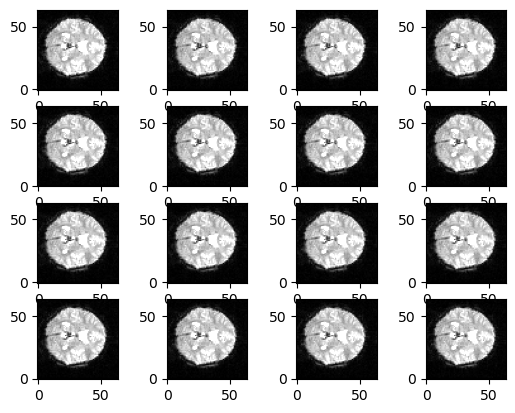

In [10]:
vmin = np.percentile(data[:, :, 10], 5)
vmax = np.percentile(data[:, :, 10], 95)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[:, :, 10, 10*i], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    # plt.axis('off')
    # plt.show()

In [11]:
data.shape

(64, 64, 25, 180)

In [12]:
# Generate the 3D coordinate grids (x, y, z) for the first three dimensions
x = np.linspace(0, data.shape[0] - 1, data.shape[0])  # x-coordinate (64)
y = np.linspace(0, data.shape[1] - 1, data.shape[1])  # y-coordinate (64)
z = np.linspace(0, data.shape[2] - 1, data.shape[2])  # z-coordinate (25)

# Create the meshgrid for all combinations of x, y, and z
x_grid, y_grid, z_grid = np.meshgrid(x, y, z, indexing='ij')

# Stack them together to get a 3D array of coordinates (x, y, z)
coordinates = np.stack([x_grid, y_grid, z_grid], axis=-1)
X = coordinates.reshape(-1, 3)

In [297]:
data_reshaped = data.reshape(-1, 180)
data_normed = data_reshaped - np.mean(data_reshaped, axis=0, keepdims=True)

In [298]:
L = 10
M = 5000

In [299]:
C = data_normed.T @ data_normed
U, S, Vt = np.linalg.svd(C)
N = data_normed.shape[0]
factors_init = ((data_normed @ U[:,:L])/np.sqrt(S[:L])).T * np.sqrt(N) #N x L   Make sure they have variance of 1
loadings_init = (U[:,:L]*np.sqrt(S[:L]))/np.sqrt(N) #J x L  

In [16]:
X_torch = torch.tensor(X).type(torch.float)
Y_torch = torch.tensor(data_normed.T).type(torch.float)

In [17]:
kmeans = KMeans(n_clusters=M, random_state=240, n_init="auto").fit(X_torch)
Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float), requires_grad=False)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f907813a0>
Traceback (most recent call last):
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has n

In [18]:
kernel = batched_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L)
gp = WSVGP(kernel, M=M, jitter=1e-5)

In [19]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X, factors_init.T)
predictions = knn_model.predict(Z.detach().numpy())

In [20]:
Lu = 1e-2*torch.eye(M).expand(L, M, M)
gp.Lu = nn.Parameter(Lu.clone().detach())
gp.Z = nn.Parameter(Z, requires_grad=False)
# gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
gp.mu = nn.Parameter(torch.tensor(predictions.T).type(torch.float))


model = Gaussian(gp=gp, y=Y_torch, L=L)
model.W = nn.Parameter(torch.tensor(loadings_init).type(torch.float))

In [49]:
def model_grads(model):
    model.prior.kernel.sigma.requires_grad = False
    model.prior.kernel.lengthscale.requires_grad = False
    model.prior.Z.requires_grad=False
    model.prior.mu.requires_grad=True
    model.prior.Lu.requires_grad=True
    model.W.requires_grad=True

In [50]:
model_grads(model)

In [51]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

In [52]:
model.prior.mu.shape

torch.Size([10, 5000])

In [25]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, **kwargs)

        logpY = pY.log_prob(y[:, idx])
        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(torch.vmap(whitened_KL)(qU.mean, qU.scale_tril))
        # ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO

        loss += 20.0*torch.sum(model.prior.kernel.lengthscale**2)
        loss += 20.0*torch.sum(model.sigma**2)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [26]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [27]:
X_train = X_torch.to(device)
Y_train = Y_torch.to(device)

In [28]:
model.prior.mu.shape

torch.Size([10, 5000])

In [223]:
steps = 1500
model.to(device)

Gaussian(
  (prior): WSVGP(
    (kernel): batched_RBF()
  )
)

In [224]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3, batch_size=7000)

  0%|          | 0/1500 [00:00<?, ?it/s]

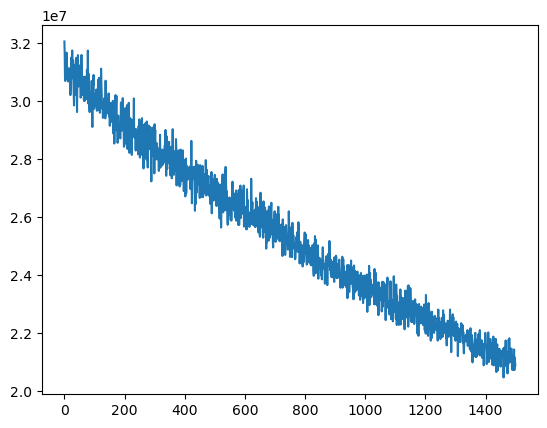

In [225]:
plt.plot(losses)

In [226]:
model.cpu()
qF, _, _ = model.prior(X_torch, verbose=True)


calculating kernels
calculating cholesky
calculating W
calculating cov_diag
calculating mean
tensor(0.0003, grad_fn=<MinBackward1>)


In [325]:
factors = qF.mean.detach().numpy()
scales = qF.scale.detach().numpy()
loadings = model.W.detach().numpy()

AttributeError: 'NMF' object has no attribute 'W'

In [326]:
loadings_means = np.mean(loadings, axis=0, keepdims=True)
loadings_signs = loadings_means/np.abs(loadings_means)

In [304]:
loadings = loadings * loadings_signs
factors = factors * (loadings_signs.T)

In [305]:
factors_reshaped = (factors.T).reshape(64, 64, 25, L)
scales_reshaped = (scales.T).reshape(64, 64, 25, L)

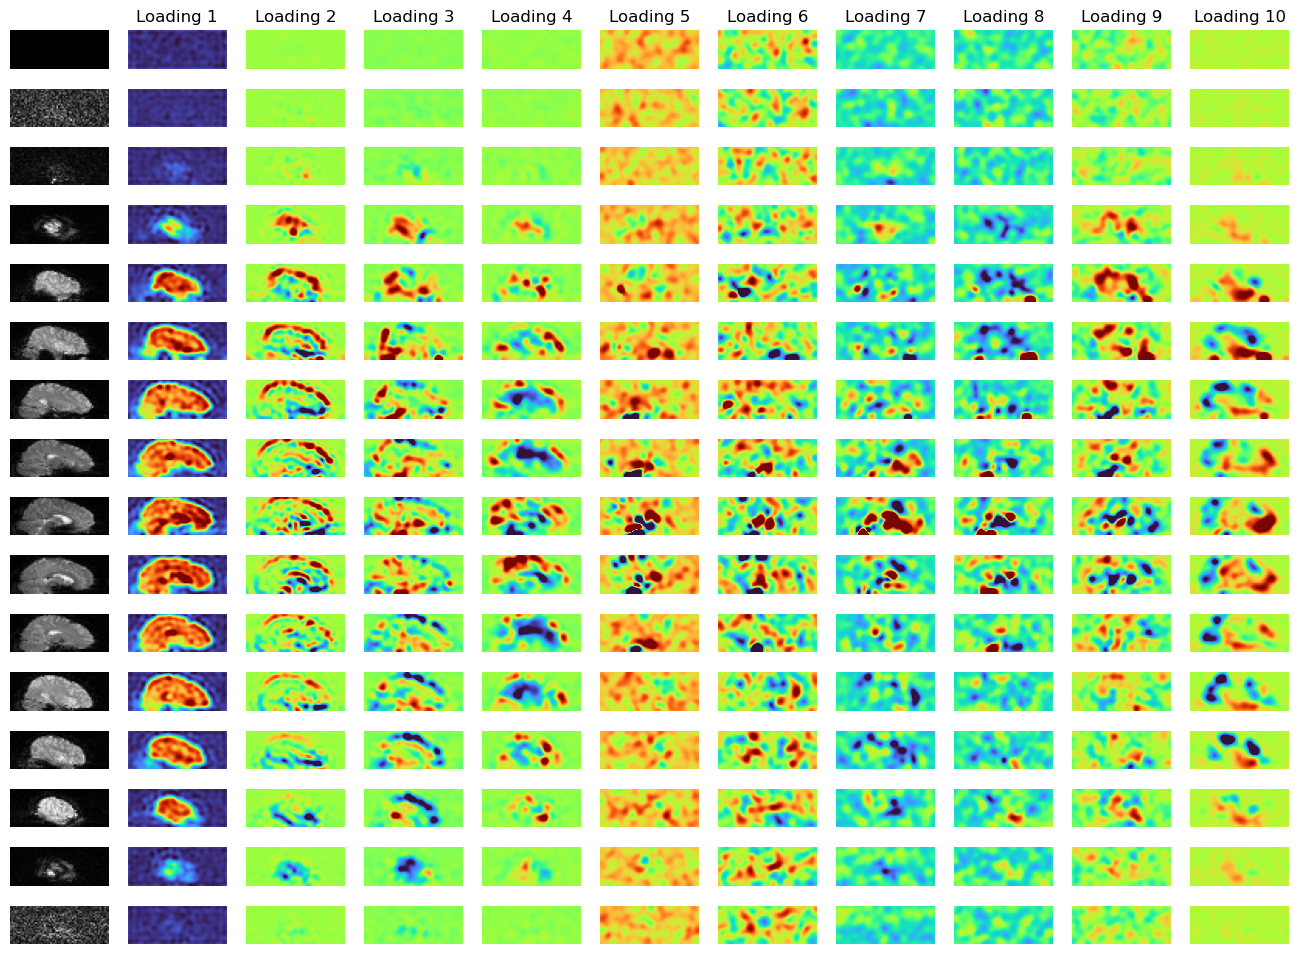

In [309]:
vmin = np.percentile(factors_reshaped, 1)
vmax = np.percentile(factors_reshaped, 99)


fig, axs = plt.subplots(16, L+1, figsize=(11*1.5, 8*1.5))
for j in range(16):
    axs[j, 0].imshow(data[4*j, :, :, 0].T, cmap='gray', origin='lower')
    axs[j, 0].axis('off')
    for i in range(L):

        vmin = np.percentile(factors_reshaped[:,:,:,i], 1)
        vmax = np.percentile(factors_reshaped[:,:,:,i], 99)
        axs[j, i+1].imshow(factors_reshaped[4*j, :, :, i].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)
        axs[j, i+1].axis('off')
        if j==0:
            axs[j, i+1].set_title('Loading '+str(i+1))
    # plt.show()

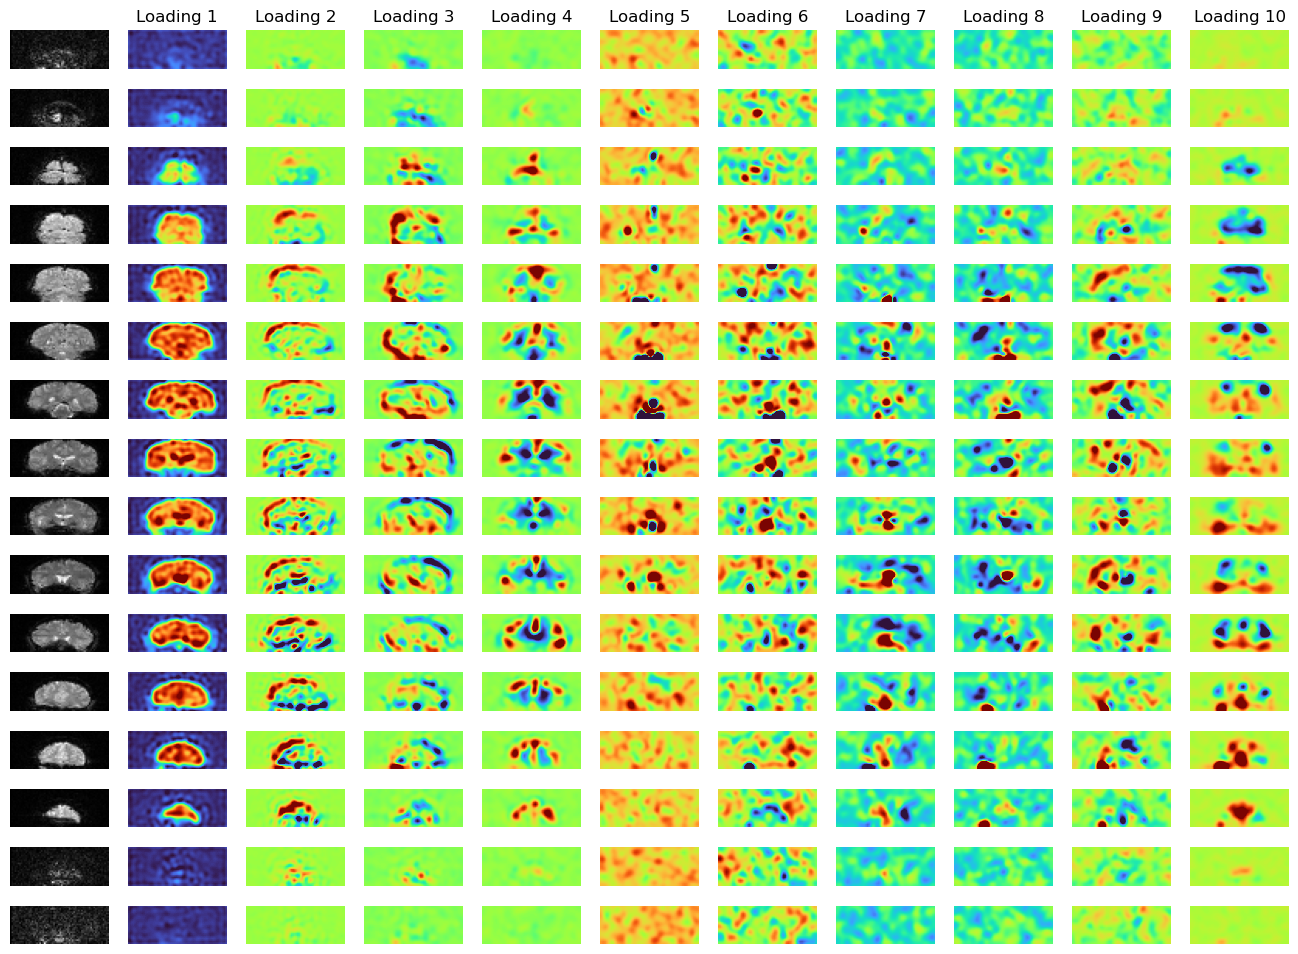

In [310]:
vmin = np.percentile(factors_reshaped, 1)
vmax = np.percentile(factors_reshaped, 99)


fig, axs = plt.subplots(16, L+1, figsize=(11*1.5, 8*1.5))
for j in range(16):
    axs[j, 0].imshow(data[:, 4*j, :, 0].T, cmap='gray', origin='lower')
    axs[j, 0].axis('off')
    for i in range(L):

        vmin = np.percentile(factors_reshaped[:,:,:,i], 1)
        vmax = np.percentile(factors_reshaped[:,:,:,i], 99)
        axs[j, i+1].imshow(factors_reshaped[:, 4*j, :, i].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)
        axs[j, i+1].axis('off')
        if j==0:
            axs[j, i+1].set_title('Loading '+str(i+1))
    # plt.show()

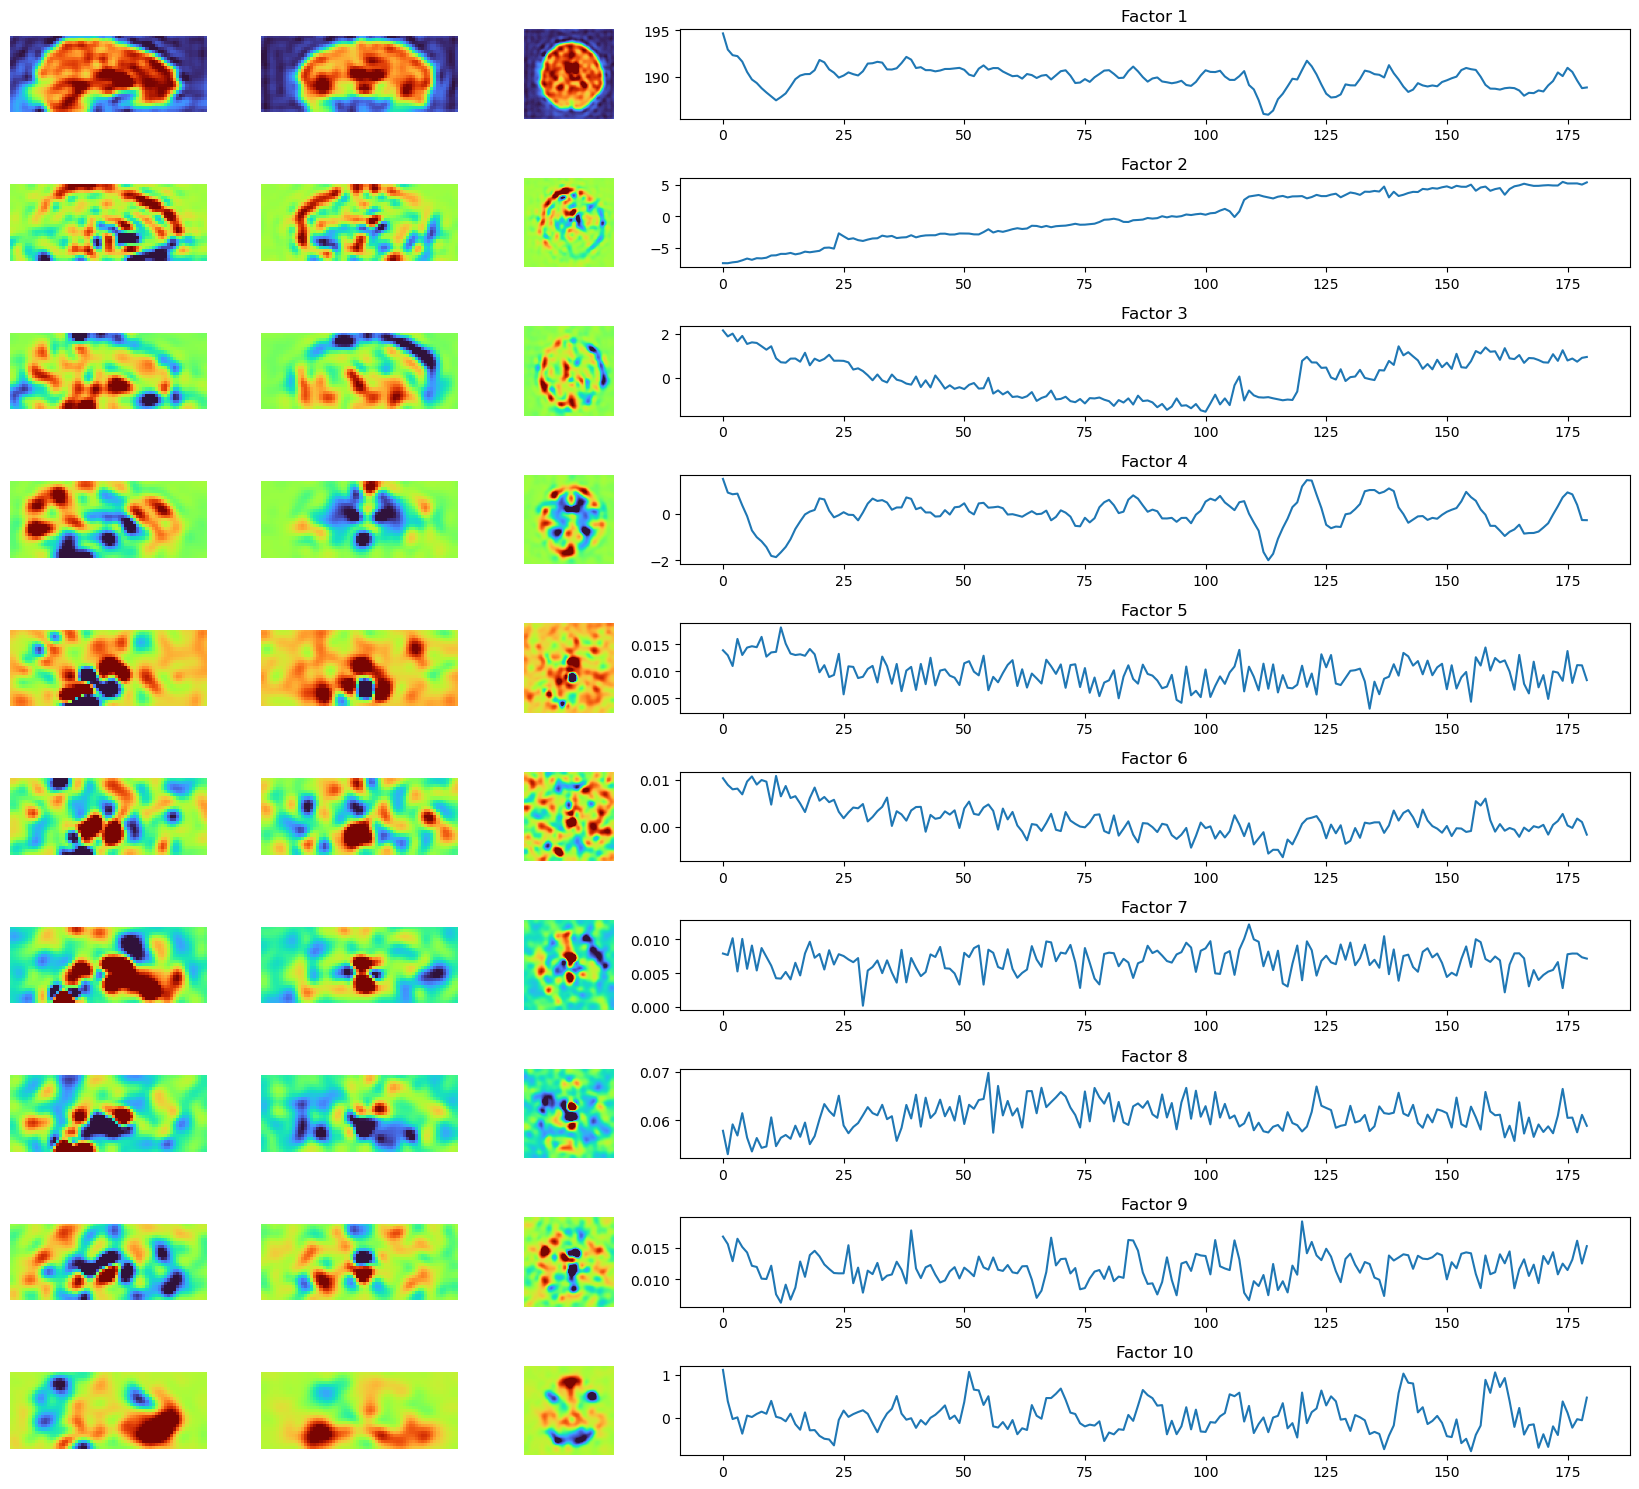

In [318]:
fig = plt.figure(figsize=(11 * 1.5, 10 * 1.5))
gs = fig.add_gridspec(L, 20)  

for j in range(L):
    vmin = np.percentile(factors_reshaped[:,:,:,j], 1)
    vmax = np.percentile(factors_reshaped[:,:,:,j], 99)
    
    ax_factor = fig.add_subplot(gs[j, :3])
    ax_factor.imshow(factors_reshaped[32, :, :, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 
    
    ax_factor = fig.add_subplot(gs[j, 3:6])
    ax_factor.imshow(factors_reshaped[:, 32, :, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 

    ax_factor = fig.add_subplot(gs[j, 6:8])
    ax_factor.imshow(factors_reshaped[:, :, 10, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 
    
    # if j == 0:
    #     ax_factor.set_title('Loading Image')  
    
    ax_loading = fig.add_subplot(gs[j, 8:])
    ax_loading.plot(loadings[:, j])  
    ax_loading.set_title(f'Factor {j+1}')
    # ax_loading.axis('off')  

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: >

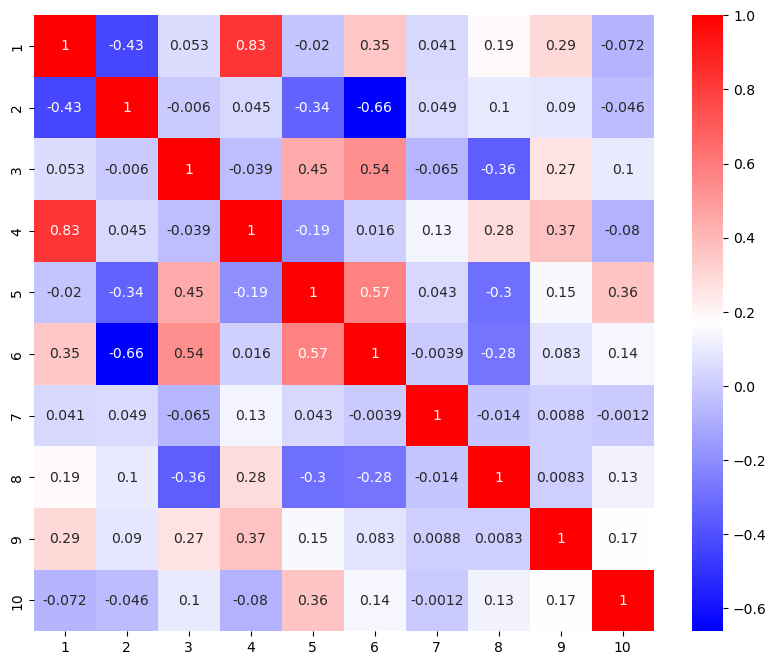

In [233]:
plt.figure(figsize=(10,8))
sns.heatmap(np.corrcoef(loadings.T), annot=True, xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 11), cmap='bwr')

In [234]:
reconstruct = ((loadings @factors).T).reshape(64, 64, 25, 180)

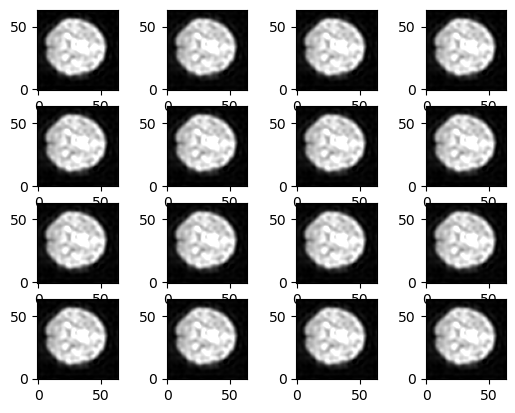

In [235]:
vmin = np.percentile(reconstruct[:, :, 10], 5)
vmax = np.percentile(reconstruct[:, :, 10], 95)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(reconstruct[:, :, 10, 10*i], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    # plt.axis('off')
    # plt.show()

In [236]:
model.sigma

Parameter containing:
tensor(16.3237, requires_grad=True)

In [69]:
np.mean((data_normed.reshape(data.shape)-reconstruct)**2)

2821.926276061716

In [238]:
np.mean((data_normed.reshape(data.shape)-reconstruct)**2)

2815.329973984295

In [377]:
from sklearn.decomposition import NMF

L=10
nmf_model = NMF(n_components=L, init='random', random_state=26, max_iter=5000, alpha_H=2e-1, alpha_W=2e-4)

In [378]:
W = nmf_model.fit_transform(data_reshaped)
H = nmf_model.components_

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


In [379]:
W_reshaped = W.reshape(64, 64, 25, L)

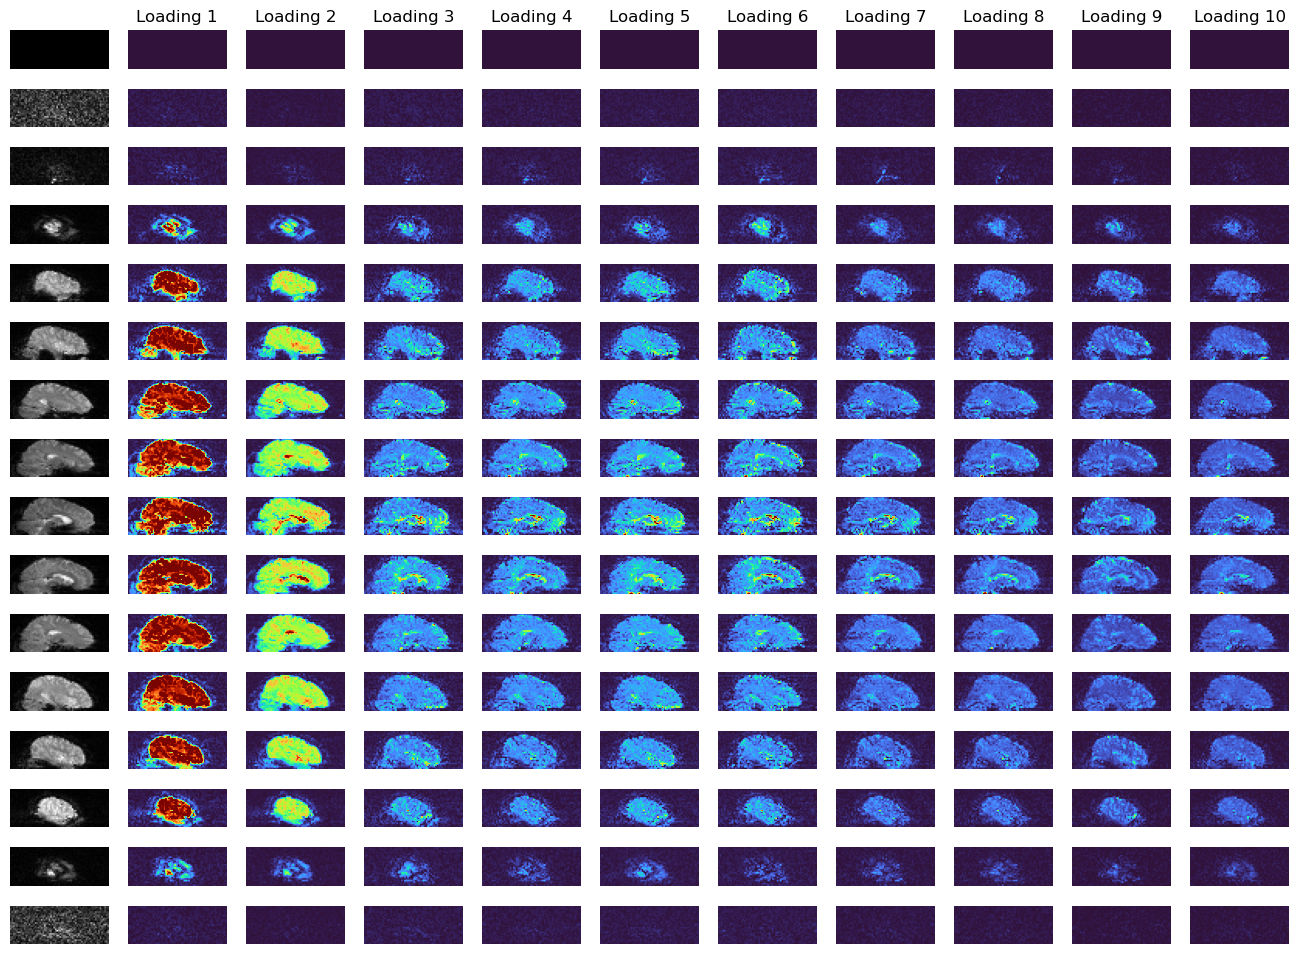

In [380]:
vmin = np.percentile(W_reshaped, 1)
vmax = np.percentile(W_reshaped, 99)


fig, axs = plt.subplots(16, L+1, figsize=(11*1.5, 8*1.5))
for j in range(16):
    axs[j, 0].imshow(data[4*j, :, :, 0].T, cmap='gray', origin='lower')
    axs[j, 0].axis('off')
    for i in range(L):

        axs[j, i+1].imshow(W_reshaped[4*j, :, :, i].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)
        axs[j, i+1].axis('off')
        if j==0:
            axs[j, i+1].set_title('Loading '+str(i+1))
    # plt.show()

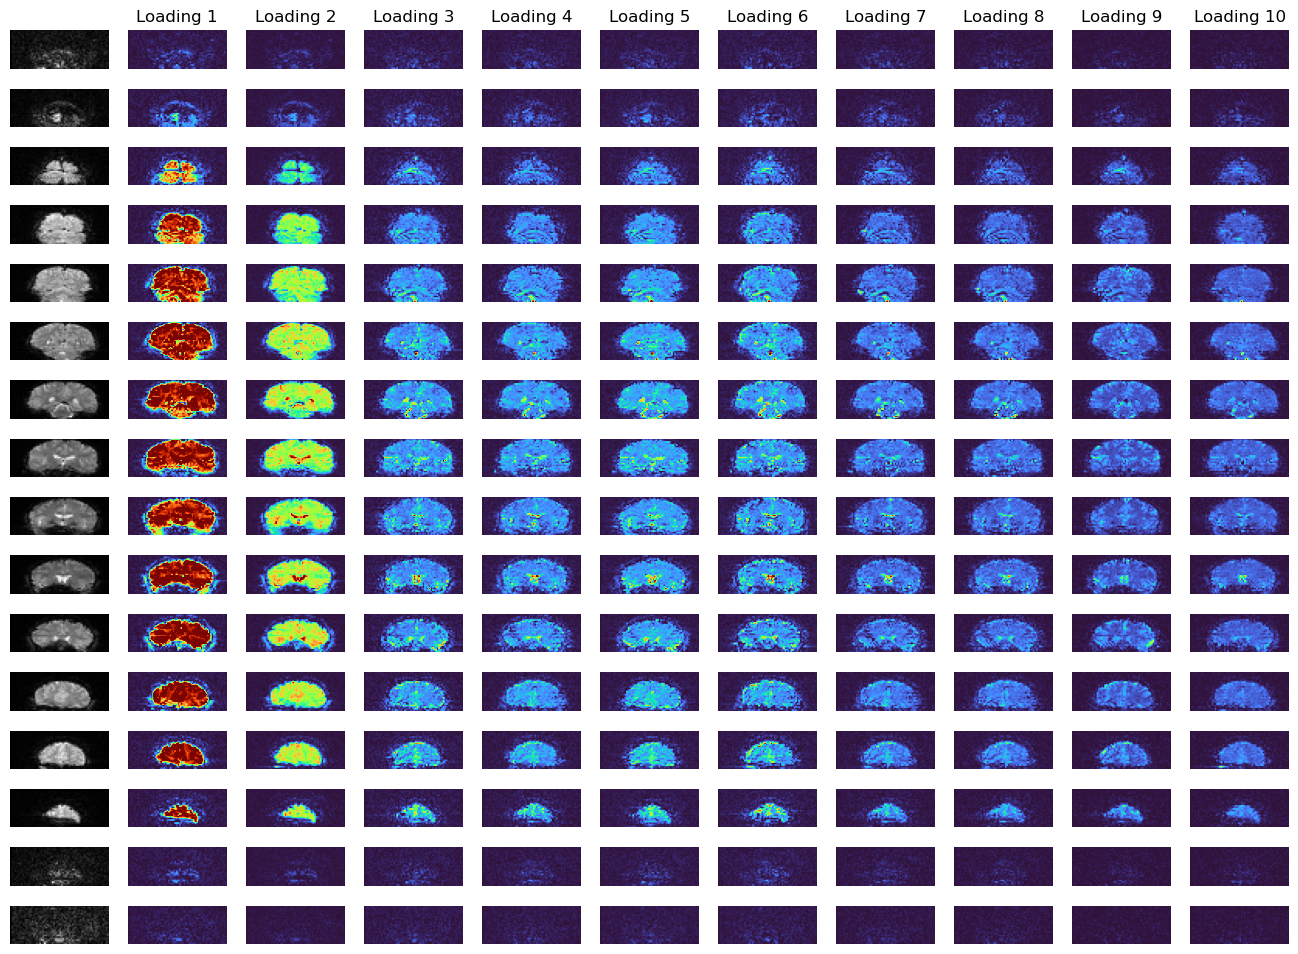

In [381]:
vmin = np.percentile(W_reshaped, 1)
vmax = np.percentile(W_reshaped, 99)


fig, axs = plt.subplots(16, L+1, figsize=(11*1.5, 8*1.5))
for j in range(16):
    axs[j, 0].imshow(data[:, 4*j, :, 0].T, cmap='gray', origin='lower')
    axs[j, 0].axis('off')
    for i in range(L):


        axs[j, i+1].imshow(W_reshaped[:, 4*j, :, i].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)
        axs[j, i+1].axis('off')
        if j==0:
            axs[j, i+1].set_title('Loading '+str(i+1))
    # plt.show()

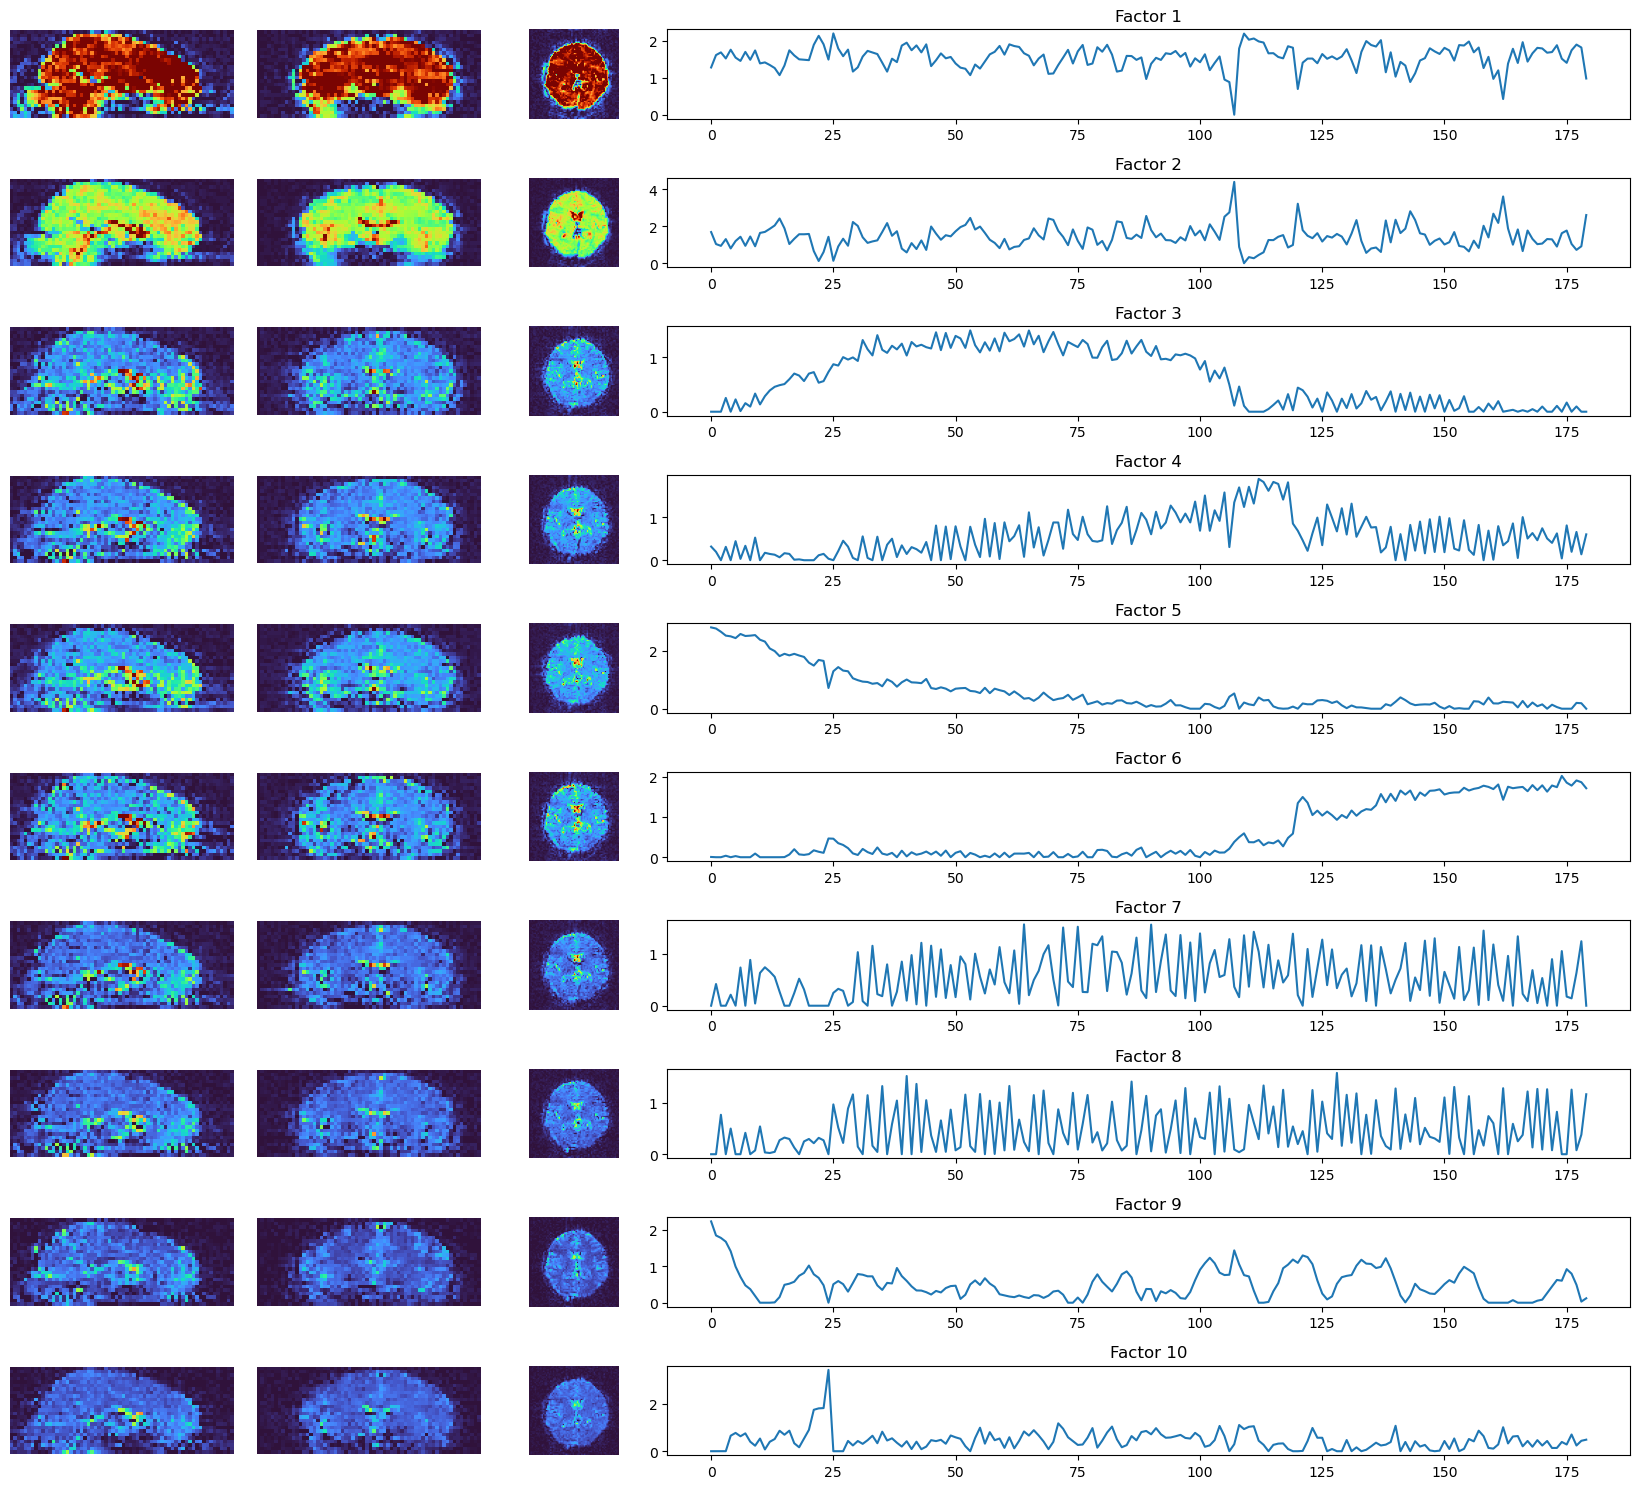

In [382]:
fig = plt.figure(figsize=(11 * 1.5, 10 * 1.5))
gs = fig.add_gridspec(L, 20)  

for j in range(L):
    vmin = np.percentile(W_reshaped, 1)
    vmax = np.percentile(W_reshaped, 99)
    
    ax_factor = fig.add_subplot(gs[j, :3])
    ax_factor.imshow(W_reshaped[32, :, :, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 
    
    ax_factor = fig.add_subplot(gs[j, 3:6])
    ax_factor.imshow(W_reshaped[:, 32, :, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 

    ax_factor = fig.add_subplot(gs[j, 6:8])
    ax_factor.imshow(W_reshaped[:, :, 10, j].T, cmap='turbo', origin='lower', vmin=vmin, vmax=vmax)  
    ax_factor.axis('off') 
    
    # if j == 0:
    #     ax_factor.set_title('Loading Image')  
    
    ax_loading = fig.add_subplot(gs[j, 8:])
    ax_loading.plot(H[j])  
    ax_loading.set_title(f'Factor {j+1}')
    # ax_loading.axis('off')  

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()